In [ ]:
# snowpit first
import pandas as pd

df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_insitu.parq')
df = df.loc[df.site_name != 'jackson']

import rioxarray as rxa
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/')

from insitu import get_uavsar_insitu

from itertools import product

insitu_UV = pd.DataFrame()

for f in ncs_dir.glob('*.sd.nc'):
    ds = xr.open_dataset(f)
    df1, df2 = get_uavsar_insitu(df, ds)
    df1, df2 = df1.reset_index(names = 'datetime'), df2.reset_index(names = 'end_datetime')
    df1, df2 = df1.set_index(['site_name']), df2.set_index(['site_name'])
    df2['dSWE'] = df2['SWE'] - df1['SWE']
    df2['dSWE-A'] = df2['SWE-A'] - df1['SWE-A']
    df2['dSWE-B'] = df2['SWE-B'] - df1['SWE-B']
    df2['dSD'] = df2['SD'] - df1['SD']
    df2['dTime'] = df2['end_datetime'] - df1['datetime']
    for i, r in df2.iterrows():

        for img_type, band in product(['int', 'unw'], ['VV','VH','HV','HH']):
            if img_type not in ds.data_vars or band not in ds.band:
                continue

            tol = 0.00090009 # ~0.001 degrees or ~100m
            df2.loc[i, f'UV_{img_type}_{band}_sd'] = ds[f'sd_delta_{img_type}'].sel(band = band, y = slice(r.lat + tol, r.lat - tol), x = slice(r.lon - tol, r.lon + tol)).mean(skipna = True)
    
    insitu_UV = pd.concat([insitu_UV, df2.reset_index(names = 'site_name')], axis = 0)

In [8]:
import pandas as pd
df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar.parq')
df = df.loc[df.site_name != 'jackson']
df = df.loc[df.dSD > 0.8]
df[['site_name', 'dSD', 'end_datetime', 'dTime']]

,site_name,dSD,end_datetime,dTime
0,banner,0.8382,2020-01-31,42 days
2,mores,0.9906,2020-01-31,42 days
3,Banner Open,0.8600,2020-01-30,43 days
4,Banner Snotel,0.8400,2020-01-30,43 days


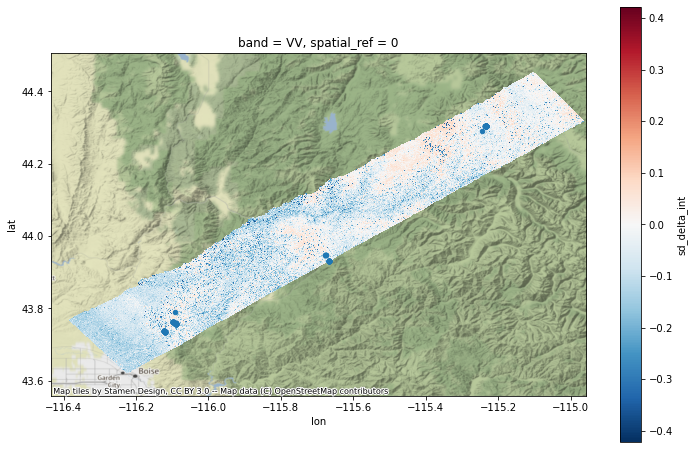

In [21]:
import contextily as ctx
import matplotlib.pyplot as plt
import xarray as xr
df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar.parq')

f, ax = plt.subplots(figsize = (12, 8))

ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/232_2021-02-03_2021-02-10.sd.nc')

ds['sd_delta_int'].sel(band = 'VV').plot(ax = ax)

df.plot.scatter(x = 'lon', y = 'lat', ax= ax)
ctx.add_basemap(ax = ax, crs= 'EPSG:4326')

Text(0, 0.5, 'Unwrapped UAVSAR SD')

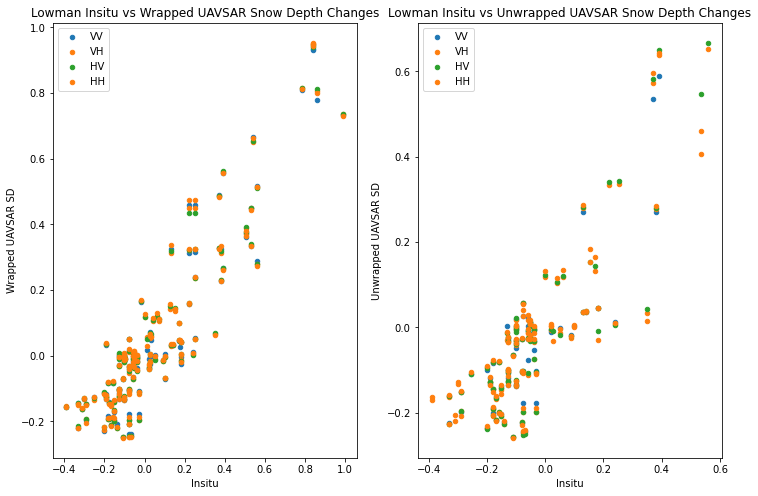

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (12,8))

df.plot.scatter(x = 'dSD', y = 'UV_int_VV_sd', ax= axes[0], label = 'VV')
df.plot.scatter(x = 'dSD', y = 'UV_int_VH_sd', ax= axes[0], color = 'C1', label = 'VH')
df.plot.scatter(x = 'dSD', y = 'UV_int_HV_sd', ax= axes[0], color = 'C2', label = 'HV')
df.plot.scatter(x = 'dSD', y = 'UV_int_HH_sd', ax= axes[0], color = 'C1', label = 'HH')
axes[0].set_title('Lowman Insitu vs Wrapped UAVSAR Snow Depth Changes')
axes[0].set_xlabel('Insitu')
axes[0].set_ylabel('Wrapped UAVSAR SD')

df.plot.scatter(x = 'dSD', y = 'UV_unw_VV_sd', ax= axes[1], label = 'VV')
df.plot.scatter(x = 'dSD', y = 'UV_unw_VH_sd', ax= axes[1], color = 'C1', label = 'VH')
df.plot.scatter(x = 'dSD', y = 'UV_unw_HV_sd', ax= axes[1], color = 'C2', label = 'HV')
df.plot.scatter(x = 'dSD', y = 'UV_unw_HH_sd', ax= axes[1], color = 'C1', label = 'HH')
axes[1].set_title('Lowman Insitu vs Unwrapped UAVSAR Snow Depth Changes')
axes[1].set_xlabel('Insitu')
axes[1].set_ylabel('Unwrapped UAVSAR SD')